# Volatility Parity Strategy

## Abstract

This Volatility Parity (VolParity) investment strategy aims to construct a risk-balanced portfolio by allocating capital such that each asset contributes equally to the overall portfolio volatility. Unlike traditional portfolios that allocate based on notional weights or expected returns, Volatility Parity targets a pre-specified level of total portfolio risk and adjusts exposures dynamically based on the assets' recent observed volatilities. This results in a more diversified and stable risk allocation, potentially offering improved risk-adjusted returns and reduced drawdowns, especially during periods of market stress. The strategy is particularly suited for multi-asset portfolios encompassing equities, bonds, credit, and commodities.

## Methodology

### Data:
The strategy uses a selection of liquid ETFs representing major asset classes: U.S. equities (SPY, QQQ), emerging markets (EEM), U.S. Treasury bonds (TLT, IEF), corporate and high-yield credit (LQD, HYG), and gold (GLD).

### Return and Volatility Estimation:

Returns are computed using log returns on daily price data.
Each asset’s volatility is estimated via an exponentially weighted moving average (EWMA) over a rolling window (span = 30 or 60 days).

Weight Construction:
Asset weights are set inversely proportional to their estimated volatility
Weights are normalized to sum to 1 across the portfolio.
The entire portfolio is scaled to target a predefined annualized volatility (15%).

### Backtesting & Rebalancing:

The portfolio is rebalanced with a 1-day implementation lag.
Transaction costs are incorporated (10 bps per round-trip).
Historical backtests generate performance statistics and risk metrics.

A comprehensive strategy factsheet is created, showing cumulative returns, volatility, drawdowns, turnover, and comparison against benchmarks ( SPY, TLT). Group-level exposures and P&L decomposition are visualized based on asset class groupings.



In [ ]:
!pip install qis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 523.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.2/750.2 kB 18.3 MB/s eta 0:00:00
  Created wheel for qis: filename=qis-3.2.17-py3-none-any.whl size=348526 sha256=84dbdaa3e92e0f78dc3aef8f651a3d4d2cf0a7ef7c6dbfd1599aaefccc94fb0f
  Stored in directory: /root/.cache/pip/wheels/0a/4f/b5/e435f11c267721bfeac53681ce2706be7e8569ad245990e174
Successfully built qis


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'shape' of type none
[1m
File "../usr/local/lib/python3.11/dist-packages/qis/models/linear/ewm.py", line 254:[0m
[1mdef compute_ewm_covar(a: np.ndarray,
    <source elided>
    else:  # must use numba >= 0.61.2
[1m        assert a.shape[0] == b.shape[0]
[0m        [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at /usr/local/lib/python3.11/dist-packages/qis/models/linear/ewm.py (254)[0m
[1m
File "../usr/local/lib/python3.11/dist-packages/qis/models/linear/ewm.py", line 254:[0m
[1mdef compute_ewm_covar(a: np.ndarray,
    <source elided>
    else:  # must use numba >= 0.61.2
[1m        assert a.shape[0] == b.shape[0]
[0m        [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function compute_ewm_covar at 0x7e26d465dc60>))[0m
[0m[1mDuring: typing of call at /usr/local/lib/python3.11/dist-packages/qis/portfolio/ewm_portfolio_risk.py (116)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function compute_ewm_covar at 0x7e26d465dc60>))[0m
[0m[1mDuring: typing of call at /usr/local/lib/python3.11/dist-packages/qis/portfolio/ewm_portfolio_risk.py (116)
[0m
[1m
File "../usr/local/lib/python3.11/dist-packages/qis/portfolio/ewm_portfolio_risk.py", line 116:[0m
[1mdef compute_portfolio_var_np(returns: np.ndarray,
    <source elided>
    # use insample ewma covar
[1m    last_covar = compute_ewm_covar(a=returns, span=span)
[0m    [1m^[0m[0m


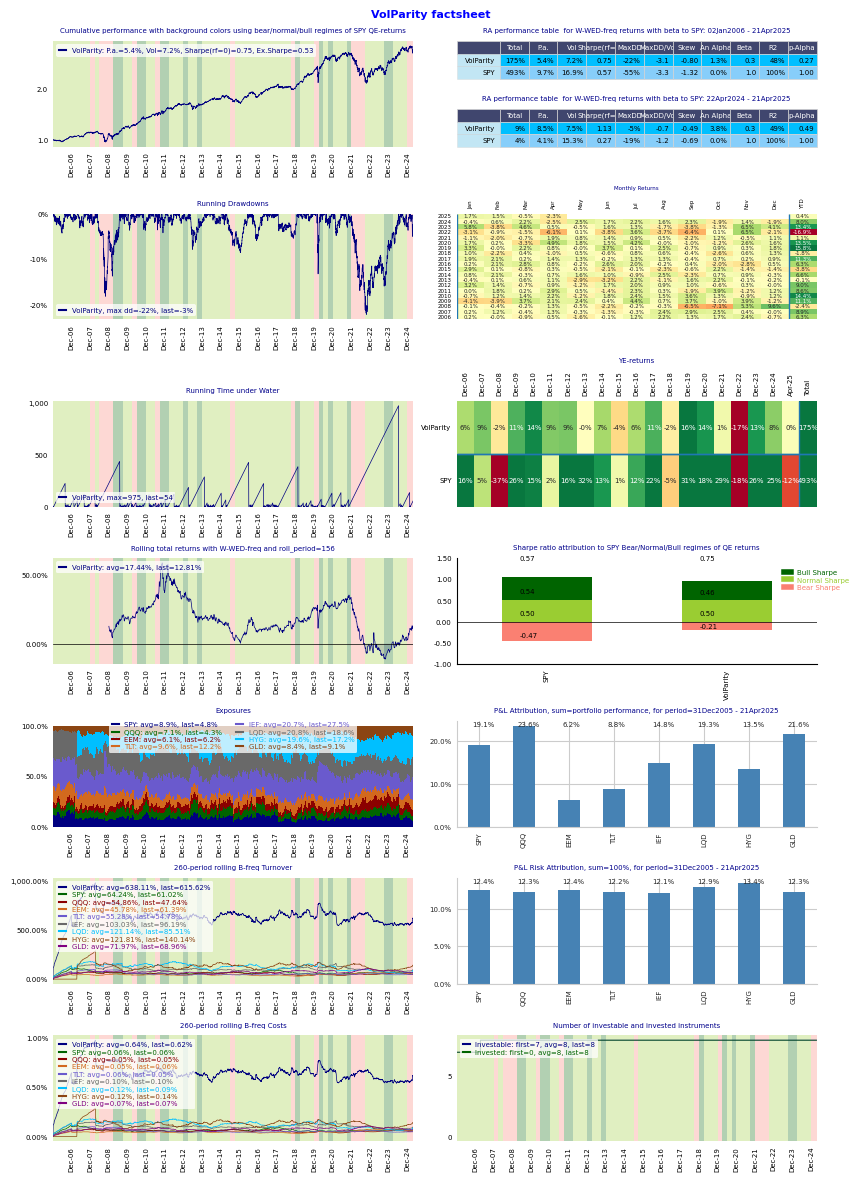

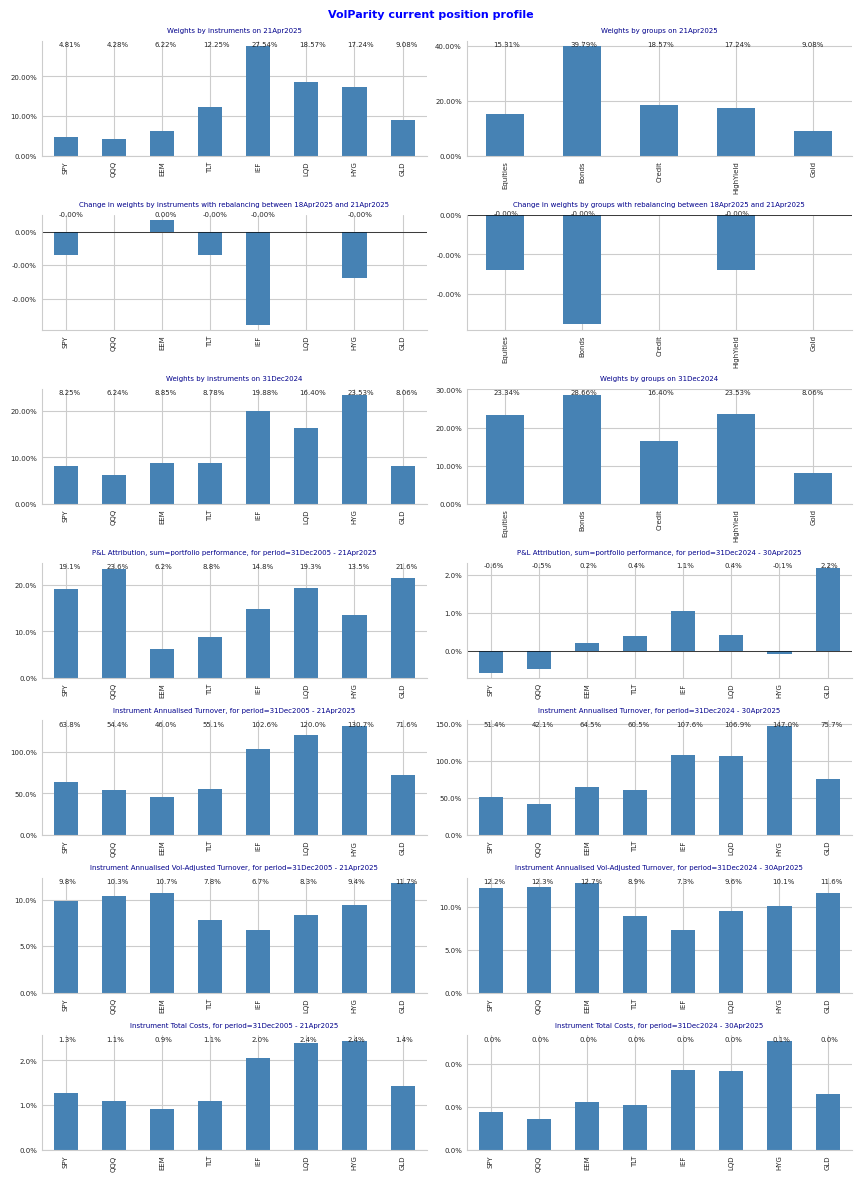

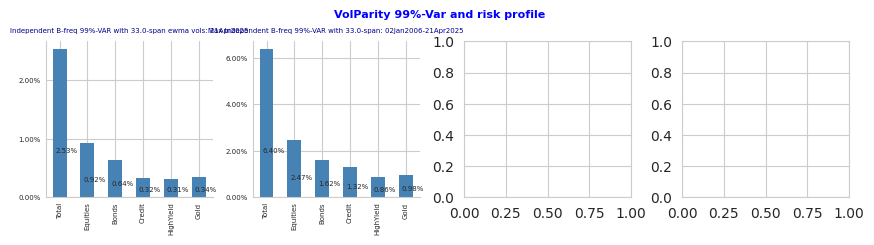

In [ ]:
import numpy as np
import pandas as pd
from typing import Tuple, List
from enum import Enum
import yfinance as yf
import qis
from qis import TimePeriod, PortfolioData
from qis.portfolio.reports.config import fetch_default_report_kwargs

def safe_download(tickers: List[str], start: str = '2005-01-01') -> pd.DataFrame:
    valid_prices = {}
    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start, progress=False, ignore_tz=True)['Close']
            if not df.empty:
                valid_prices[ticker] = df
            else:
                print(f"⚠️ No data for ticker: {ticker}")
        except Exception as e:
            print(f" Failed to download '{ticker}': {e}")

    if not valid_prices:
        raise ValueError(" All ticker downloads failed. Check internet connection or symbols.")

    prices_df = pd.concat(valid_prices.values(), axis=1)
    prices_df.columns = list(valid_prices.keys())
    return prices_df

def fetch_universe_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    universe_data = dict(SPY='Equities',
                         QQQ='Equities',
                         EEM='Equities',
                         TLT='Bonds',
                         IEF='Bonds',
                         LQD='Credit',
                         HYG='HighYield',
                         GLD='Gold')

    tickers = list(universe_data.keys())
    group_data = pd.Series(universe_data)

    prices = safe_download(tickers)
    prices = prices.asfreq('B', method='ffill')

    available = [t for t in ['SPY', 'TLT'] if t in prices.columns]
    if len(available) < 2:
        print("⚠️ Benchmark components missing. Using first two available tickers as benchmark.")
        available = list(prices.columns[:2])
    benchmark_prices = prices[available]

    return prices, benchmark_prices, group_data.loc[prices.columns]

def fetch_equity_bond() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    universe_data = dict(SPY='Equities', IEF='Bonds')
    tickers = list(universe_data.keys())
    group_data = pd.Series(universe_data)
    prices = safe_download(tickers)
    benchmark_prices = prices.loc[:, prices.columns.intersection(['SPY', 'IEF'])]
    return prices, benchmark_prices, group_data.loc[prices.columns]

def generate_volparity_portfolio(prices: pd.DataFrame,
                                 group_data: pd.Series,
                                 time_period: TimePeriod = None,
                                 span: int = 60,
                                 vol_target: float = 0.15,
                                 rebalancing_costs: float = 0.0010) -> PortfolioData:
    if prices.empty:
        raise ValueError("Price data is empty. Cannot generate portfolio.")

    returns = qis.to_returns(prices=prices, is_log_returns=True)
    if returns is None or not isinstance(returns, pd.DataFrame) or returns.empty:
        raise ValueError("Return series is missing or invalid after conversion.")

    ra_returns, weights, ewm_vol = qis.compute_ra_returns(returns=returns,
                                                          span=span,
                                                          vol_target=vol_target)
    weights = weights.divide(weights.sum(1), axis=0)

    if time_period is not None:
        weights = time_period.locate(weights)

    portfolio = qis.backtest_model_portfolio(prices=prices,
                                             weights=weights,
                                             rebalancing_costs=rebalancing_costs,
                                             weight_implementation_lag=1,
                                             ticker='VolParity')
    portfolio.set_group_data(group_data=group_data, group_order=list(group_data.unique()))
    return portfolio

def generate_equity_bond_portfolio(prices: pd.DataFrame,
                                   weights: List[float],
                                   group_data: pd.Series,
                                   rebalancing_costs: float = 0.0010) -> PortfolioData:
    portfolio = qis.backtest_model_portfolio(prices=prices,
                                             weights=weights,
                                             rebalancing_costs=rebalancing_costs,
                                             ticker='EquityBond')
    portfolio.set_group_data(group_data=group_data, group_order=list(group_data.unique()))
    return portfolio

class UnitTests(Enum):
    VOLPARITY_PORTFOLIO = 1
    EQUITY_BOND = 2
    DELTA1_STRATEGY = 3

def run_unit_test(unit_test: UnitTests):
    time_period = TimePeriod('31Dec2005', '21Apr2025')
    rebalancing_costs = 0.0010

    if unit_test == UnitTests.VOLPARITY_PORTFOLIO:
        prices, benchmark_prices, group_data = fetch_universe_data()
        portfolio_data = generate_volparity_portfolio(prices=prices,
                                                      group_data=group_data,
                                                      time_period=time_period,
                                                      span=30,
                                                      vol_target=0.15,
                                                      rebalancing_costs=rebalancing_costs)
        figs = qis.generate_strategy_factsheet(portfolio_data=portfolio_data,
                                               benchmark_prices=benchmark_prices,
                                               time_period=time_period,
                                               add_current_position_var_risk_sheet=True,
                                               add_weights_turnover_sheet=True,
                                               add_grouped_exposures=False,
                                               add_grouped_cum_pnl=False,
                                               add_weight_change_report=False,
                                               add_current_signal_report=False,
                                               add_instrument_history_report=True,
                                               **fetch_default_report_kwargs(time_period=time_period))
        qis.save_figs_to_pdf(figs=figs,
                             file_name=f"{portfolio_data.nav.name}_strategy_factsheet_long",
                             local_path=qis.local_path.get_output_path())

    elif unit_test == UnitTests.EQUITY_BOND:
        prices, benchmark_prices, group_data = fetch_equity_bond()
        portfolio_data = generate_equity_bond_portfolio(prices=prices,
                                                        weights=[0.6, 0.4],
                                                        group_data=group_data,
                                                        rebalancing_costs=rebalancing_costs)
        figs = qis.generate_strategy_factsheet(portfolio_data=portfolio_data,
                                               benchmark_prices=benchmark_prices,
                                               add_grouped_exposures=True,
                                               add_grouped_cum_pnl=True,
                                               time_period=time_period,
                                               **fetch_default_report_kwargs(time_period=time_period))
        qis.save_figs_to_pdf(figs=figs,
                             file_name=f"{portfolio_data.nav.name}_portfolio_factsheet_long",
                             local_path=qis.local_path.get_output_path())

    elif unit_test == UnitTests.DELTA1_STRATEGY:
        from bbg_fetch import fetch_field_timeseries_per_tickers
        prices = fetch_field_timeseries_per_tickers(tickers={'UISYMH5S Index': 'CDX_HY'})
        benchmark_prices = fetch_field_timeseries_per_tickers(tickers={'HYG US Equity': 'HYG'})

        delta1_portfolio = qis.backtest_model_portfolio(prices=prices,
                                                        weights=np.array([1.0]),
                                                        rebalancing_freq='SE',
                                                        rebalancing_costs=rebalancing_costs,
                                                        ticker='Delta1')
        figs = qis.generate_strategy_factsheet(portfolio_data=delta1_portfolio,
                                               benchmark_prices=benchmark_prices,
                                               add_current_position_var_risk_sheet=False,
                                               time_period=time_period,
                                               **fetch_default_report_kwargs(time_period=time_period))
        qis.save_figs_to_pdf(figs=figs,
                             file_name=f"delta1_strategy_factsheet",
                             local_path=qis.local_path.get_output_path())

if __name__ == '__main__':
    unit_test = UnitTests.VOLPARITY_PORTFOLIO
    is_run_all_tests = False

    if is_run_all_tests:
        for unit_test in UnitTests:
            run_unit_test(unit_test=unit_test)
    else:
        run_unit_test(unit_test=unit_test)